In [9]:
import setGPU0
import os
from io_functions import *
from draw_functions import *
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
#from keras.utils.visualize_util import plot, model_to_dot
from IPython.display import SVG
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from niki_visual import *

using gpu0


In [ ]:
## Here we build a model of our choosing
""" 
Want to be able to specify:
- # of nodes in dense layer     (int)
- # of dense layers             (int)
- # of branches. for each one, list of tuples of branches and 
- # of filters                  (int)
- # of branches in convolution  (int)
- dimensions for each branch    (list of tuples)
- dropout
- patience

each branch should have the possibility of having multiple convolutional layers
"""

In [ ]:
def old_build_model(num_branch=0, conv_per_branch=1, per_branch={(0,0):(4, 4, 5)}, filters=3, num_dense=1, num_nodes=10, dropout=0.5, patience=5):
    # Make the list of models
    models = [ None ] * num_branch
    
    # Initialize the models (model is the central, final, dense, merged one)
    model = Sequential()
    for i, j in enumerate(models):
        models[i] = Sequential(name='Branch%s'%i+'; %s Conv Layers'%conv_per_branch)
        
    # Add in the convolutional branches and layers (if there are any)
    if num_branch: # (check if there are any convolutional layers)
        for i in range(num_branch):
            for j in range(conv_per_branch):
                # Only specify shape if it's the first layer of the branch
                if not j:
                    models[i].add(Convolution3D(filters, per_branch[i,j][0], per_branch[i,j][1], per_branch[i,j][2],
                                                input_shape = (1, 20, 20, 25), activation='relu'))
                else:
                    models[i].add(Convolution3D(filters, per_branch[i,j][0], per_branch[i,j][1], per_branch[i,j][2]))
            models[i].add(MaxPooling3D())
            models[i].add(Flatten())
    
        # Combine the branches
        model.add(Merge(models, mode='concat', name='Merge'))
                              
        # Add in the dense layers
        for i in range(num_dense):
            model.add(Dense(num_nodes, activation='relu', name='Dense %s'%i))
            model.add(Dropout(dropout, name='%s Dropout'%dropout))
    else: # (no convolutional layers)
        # Add in the dense layers
        for i in range(num_dense):
            model.add(Dense(num_nodes, activation='relu', input_dim=10000), name='Dense %s'%i)
            model.add(Dropout(dropout, name='%s Dropout'%dropout))
    
    # Add output layer, compile, and return it
    model.add(Dense(1, init='uniform', activation='sigmoid', name='Binary Output'))
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    return model

In [5]:
def build_model(num_branch=0, conv_per_branch=1, per_branch={(0,0):(4, 4, 5)}, filters=3, num_dense=1,
                num_nodes=10, dropout=0.5, patience=5):
    # Make the list of models
    models = []
    
    # Initialize the models (model is the central, final, dense, merged one)
    inputs = Input(shape=(1, 20, 20, 25), name='Input Layer')
      
    # Add in the convolutional branches and layers (if there are any)
    if num_branch: # (check if there are any convolutional layers)
        for i in range(num_branch):
            for j in range(conv_per_branch):
                # Only specify shape if it's the first layer of the branch
                a,b,c = per_branch[i,j][0], per_branch[i,j][1], per_branch[i,j][2]
                if not j:
                    x = Convolution3D(filters, a, b, c,
                                      input_shape = (1, 20, 20, 25), activation='relu',
                                      name=str((a,b,c))+' 3D Conv, B%s'%i+' L%s'%j)(inputs)
                else:
                    x = Convolution3D(filters, a, b, c,
                                      activation='relu', name=str((a,b,c))+' 3D Conv, B%s'%i+' L%s'%j)(x)
            x = MaxPooling3D(name='MaxPooling3D, B%s'%i)(x)
            models.append(Flatten(name='Flatten, B%s'%i)(x))
            
        # Combine the branches
        x = merge(models, mode='concat', name='Merge Layer')
                              
        # Add in the dense layers
        for i in range(num_dense):
            x = Dense(num_nodes, activation='relu', name='Dense %s'%i)(x)
            x = Dropout(dropout, name='%s Dropout'%dropout)(x)
    else: # (no convolutional layers)
        # Add in the dense layers
        for i in range(num_dense):
            x = Dense(num_nodes, activation='relu', input_dim=10000, name='Dense %s'%i)(x)
            x = Dropout(dropout, name='%s Dropout'%dropout)(x)
    
    # Add output layer, compile, and return it
    x = Dense(1, init='uniform', activation='sigmoid', name='Binary Output Layer')(x)
    model = Model(input=inputs, output=x)
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    return model


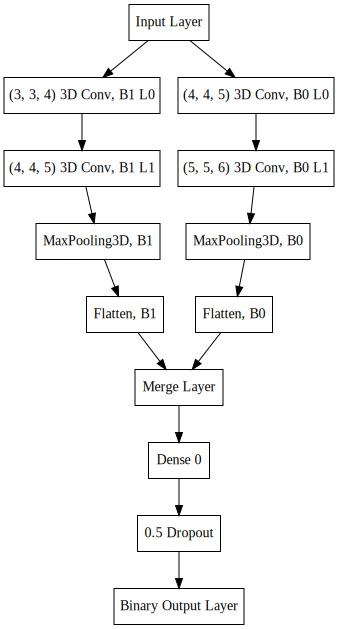

In [6]:
model = build_model(2, 2, {(0,0):(4, 4, 5), (1,0):(3,3,4), (0,1):(5,5,6), (1,1):(4,4,5)}, filters=3, num_dense=1, num_nodes=100, dropout=0.5, patience=5)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [19]:
# 1 is signal; 0 is background
train_data, test_data, train_labels, test_labels = train_test(shape=(1, 20, 20, 25), split=0.33)

In [22]:
train_data = train_data[:100]
train_labels = train_labels[:100]

(100, 1, 20, 20, 25)

In [23]:
# Checkpointing and Early Stopping
check = ModelCheckpoint(filepath="./tmp/conv10test.hdf5", verbose=1)
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# Train the network
my_fit = model.fit(train_data, train_labels, nb_epoch=2, validation_split=0.2, batch_size=1000,
                   verbose=1, callbacks=[check, early])

Train on 80 samples, validate on 20 samples
Epoch 1/2
Epoch 00000: saving model to ./tmp/conv10test.hdf5
80/80 [==============================] - 0s - loss: 1.8040 - val_loss: 5.5798
Epoch 2/2
Epoch 00001: saving model to ./tmp/conv10test.hdf5
80/80 [==============================] - 0s - loss: 6.0700 - val_loss: 2.3519


In [12]:
def build_model_2(num_branch=0, conv_per_branch=1, filters=3, num_dense=1,
                num_nodes=10, dropout=0.5, patience=5):
    # Make the list of models
    models = []
    
    # Initialize the models (model is the central, final, dense, merged one)
    inputs = Input(shape=(1, 20, 20, 25), name='Input Layer')
      
    # Add in the convolutional branches and layers (if there are any)
    if num_branch: # (check if there are any convolutional layers)
        for i in range(num_branch):
            for j in range(conv_per_branch):
                # Default 3,3,4; increase based on branch/depth (I think this is the best way to do this?)
                a, b, c = 3+i+j, 3+i+j, 4+i+j
                # Only specify shape if it's the first layer of the branch
                if not j:
                    x = Convolution3D(filters, a, b, c,
                                      input_shape = (1, 20, 20, 25), activation='relu',
                                      name=str((a,b,c))+' 3D Conv, B%s'%i+' L%s'%j)(inputs)
                else:
                    x = Convolution3D(filters, a, b, c,
                                      activation='relu', name=str((a,b,c))+' 3D Conv, B%s'%i+' L%s'%j)(x)
            x = MaxPooling3D(name='MaxPooling3D, B%s'%i)(x)
            models.append(Flatten(name='Flatten, B%s'%i)(x))
            
        # Combine the branches
        x = merge(models, mode='concat', name='Merge Layer')
                              
        # Add in the dense layers
        for i in range(num_dense):
            x = Dense(num_nodes, activation='relu', name='Dense, '+'N%s '%num_nodes+'L%s'%i)(x)
            x = Dropout(dropout, name='Dropout of %s'%dropout)(x)
    else: # (no convolutional layers)
        # Add in the dense layers
        for i in range(num_dense):
            x = Dense(num_nodes, activation='relu', input_dim=10000, name='Dense, '+'N%s '%num_nodes+'L%s'%i)(x)
            x = Dropout(dropout, name='Dropout of %s'%dropout)(x)
    
    # Add output layer, compile, and return it
    x = Dense(1, init='uniform', activation='sigmoid', name='Binary Output Layer')(x)
    model = Model(input=inputs, output=x)
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    return model

In [ ]:
# Checkpointing and Early Stopping
def branin(num_branch, conv_per_branch, filters, num_dense, num_nodes, dropout, patience)
    model = build_model_2(num_branch, conv_per_branch, filters, num_dense, num_nodes, dropout, patience)
    check = ModelCheckpoint(filepath="./tmp/test%s.hdf5"%num_dense, verbose=1)
    early = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

    # Train the network
    my_fit = model.fit(np.swapaxes(train_data, 1, 3), train_labels, nb_epoch=10000, validation_split=0.2,
                   batch_size=1000, verbose=1, callbacks=[check, early])
    return my_fit.history['loss'][-1] # get the last element in the loss

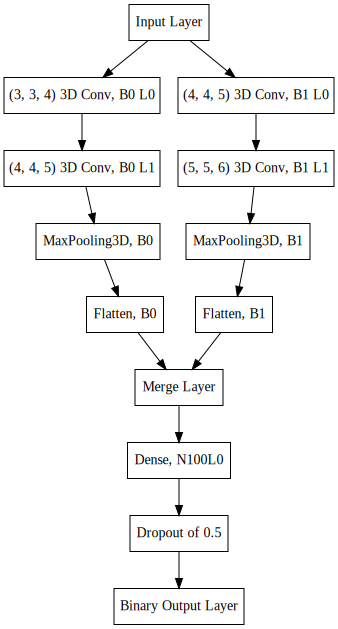

In [13]:
model = build_model_2(2, 2, filters=3, num_dense=1, num_nodes=100, dropout=0.5, patience=5)
SVG(model_to_dot(model).create(prog='dot', format='svg'))